# U-Net trained on the MoNuSeg data set

In [1]:
import random
import json
from itertools import cycle
import xml.etree.ElementTree as ET
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from PIL import Image
from PIL import Image, ImageDraw
from skimage.draw import polygon
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.metrics import jaccard_score
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from keras.utils import Sequence
from keras.models import Model, load_model
from keras.layers import Input, multiply
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import pandas as pd
import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
wandb.init(project="swebcg91rt-net")

import utils
import monuseg_utils

from augmented_sequence import AugmentedSequence

In [2]:
monuseg_patinfo = pd.read_csv(Path(os.getcwd()) / 'patient_information.csv')

In [3]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
BATCH_SIZE = 20

monuseg_train_ids = monuseg_patinfo[monuseg_patinfo['training'] == 'yes']['patient_id']
monuseg_test_ids = monuseg_patinfo[monuseg_patinfo['training'] == 'no']['patient_id']

# Perform train, validation split
monuseg_train_ids, monuseg_val_ids = utils.val_split(monuseg_train_ids)

In [4]:
seq = iaa.Sequential([
    iaa.CropToFixedSize(width=round(IMG_WIDTH*1.5), height=round(IMG_HEIGHT*1.5)),
    iaa.flip.Flipud(p=0.5),
    iaa.flip.Fliplr(p=0.5),
    iaa.Affine(rotate=(-45,45)),
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT, position="center"),
    iaa.Sometimes(0.2, iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0.0, 3.0)))
    #iaa.Sometimes(0.2, iaa.EdgeDetect((0,0.5)))
])

val_sequential = iaa.Sequential([
    iaa.CropToFixedSize(width=round(IMG_WIDTH*1.5), height=round(IMG_HEIGHT*1.5)),
    iaa.flip.Flipud(p=0.5),
    iaa.flip.Fliplr(p=0.5),
    iaa.Affine(rotate=(-45,45)),
    iaa.CropToFixedSize(width=IMG_WIDTH, height=IMG_HEIGHT, position="center"),
])

train_seq = AugmentedSequence(monuseg_train_ids, BATCH_SIZE, seq, IMG_WIDTH, IMG_HEIGHT)
val_seq = AugmentedSequence(monuseg_val_ids, BATCH_SIZE, val_sequential, IMG_WIDTH, IMG_HEIGHT)

/home/karvla/.cache/pypoetry/virtualenvs/histopathnet-k7cDaRr--py3.8/lib/python3.8/site-packages/imgaug/augmentables/heatmaps.py:71: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 9.23116302). Array will be clipped to chosen value range.
  ia.warn(


## Train U-Net
The U-Net, along with the weight map loss function, was implemented by [jaidevd](https://jaidevd.github.io/posts/weighted-loss-functions-for-instance-segmentation/)

In [9]:
from weighted_loss_unet import make_weighted_loss_unet, my_loss

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection) / (union)
    return (1-jac)

model = make_weighted_loss_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 1)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_19[0][0]                  
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 64) 0           conv2d_20[0][0]                  
_______________________________________________________________________________________

float32


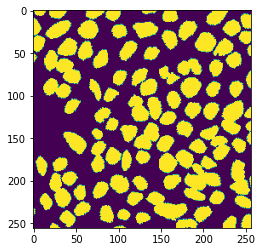

In [6]:
img, wmap = train_seq[0][0]
mask = train_seq[0][1]
print(mask[0].dtype)
plt.imshow(mask[3])

In [10]:
model.compile(optimizer='adam', loss=my_loss, metrics=iou)
model.fit(train_seq, validation_data=val_seq,
   epochs=150, callbacks=[WandbCallback()]) 

# Save model to wandb
model.save(os.path.join(wandb.run.dir, "model.h5"))

Epoch 1/150
 7/24 [=======>......................] - ETA: 13:37 - loss: 5.1380e-10 - iou: nan

KeyboardInterrupt: 